In [1]:
def apply_cmap(data, cmap='gray', clim='auto'):
    """
    Apply a matplotlib colormap to a 2D or 3D numpy array and return the rgba data in uint8 format

    data : 2D or 3D numpy array

    cmap : string denoting a matplotlib colormap
        Colormap used for displaying frames from data. Defaults to 'gray'.

    clim : length-2 list, tuple, or ndarray, or string
        Upper and lower intensity limits to display from data. Defaults to 'auto'
        If clim='auto', the min and max of data will be used as the clim.
        Before applying the colormap, data will be clipped from clim[0] to clim[1].
    """

    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    from numpy import array

    if clim == 'auto':
        clim = data.min(), data.max()

    sm = ScalarMappable(Normalize(*clim, clip=True), cmap)
    rgba = [sm.to_rgba(d, bytes=True) for d in data]

    return rgba


def nparray_to_video(fname, data, clim='auto', cmap='gray', codec='h264', fps=24,
                     ffmpeg_params=['-pix_fmt', 'yuv420p']):
    """
    Save 3D (t, y, x) numpy array to disk as movie. Uses matplotlib colormaps for rescaling / coloring data,
    and uses moviepy.editor.ImageSequenceClip for movie creation.

    Warning : this function duplicates the input data in memory.

    fname : string
        Filename with extension (.avi, .mp4, etc).

    data : 3D numpy array
        Each 2D array along the first axis of data will be a frame in the movie.

    clim : length-2 list, tuple, or ndarray, or string
        Upper and lower intensity limits to display from data. Defaults to 'auto'
        If clim='auto', the min and max of data will be used as the clim.
        Before applying the colormap, data will be clipped from clim[0] to clim[1].

    cmap : string denoting a matplotlib colormap
        Colormap used for displaying frames from data. Defaults to 'gray'.

    codec :  string
        Which video codec to use. Defaults to 'h264'. See moviepy.editor.ImageSequenceClip.writevideofile.

    fps : int or float
        Frames per second of the movie. Defaults to 24.

    ffmpeg_params : list of strings
        Arguments sent to ffmpeg during movie creation. Defaults to ['-pix_fmt', 'yuv420p'], which is necessary for
        creating movies that OSX understands.


    """
    from moviepy.editor import ImageSequenceClip

    dur = data.shape[0] / fps

    # ffmpeg errors if the dimensions of each frame are not divisible by 2
    if data.shape[1] % 2 == 1:
        data = np.pad(data, ((0, 0), (0, 1), (0, 0)), mode='minimum')
    elif data.shape[2] % 2 == 1:
        data = np.pad(data, ((0, 0), (0, 0), (0, 1)), mode='minimum')

    data_rgba = apply_cmap(data, cmap=cmap, clim=clim)
    clip = ImageSequenceClip([d for d in data_rgba], fps=fps)
    clip.write_videofile(fname, audio=False, codec=codec, fps=fps, ffmpeg_params=ffmpeg_params)

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
from matplotlib.cm import gray, inferno, magma, viridis

import numpy as np
import flika as flk


from skimage.exposure import rescale_intensity as rescale
from skimage.transform import downscale_local_mean as downscale
from fish.image.alignment import estimate_translation
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.ndimage import median_filter
from fish.image.zds import ZDS

from dask.distributed import Client
from fish.util.distributed import get_cluster
from dask.array import coarsen
import dask.array as da
from pathlib import Path
import os
flk.start_flika()

Starting flika


Starting flika inside IPython


In [3]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

20171107_1_3_gfaprgeco_gfaptrpv1_6dpf_csn_20171107_113628 :: deep (z 0 : 5) , t 4771, t 4846, 5063
20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_20171022_141052 :: giving-up triggered events are global, hard to define initiation zone
20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM :: great moment around 6230

In [4]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/20171107/fish1/20171107_1_1_gfaprgeco_gfaptrpv1_6dpf_red_20171107_111816/',
           '/nrs/ahrens/Yu/SPIM/active_dataset/20171022/fish1/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_20171022_141052/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20171107/fish2/20171107_2_3_gfaprgeco_gfaptrpv1_6dpf_csn_20171107_135106/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20171022/fish4/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_20171022_230815/')

In [5]:
from scipy.ndimage.filters import median_filter
from functools import partial

base_dir = base_dirs[-1] 
dset = ZDS(base_dir + 'raw/')
data = dset.data
exp_name = dset.metadata['data_header'] 
reg_path = base_dir + 'regparams_affine.npy'

medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)    
anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

(13501, 22, 744, 960)

In [6]:
cluster = get_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.110.35:43429 Dashboard: http://10.36.110.35:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
# plot the whole-brain mean vs time to figure out when csn was added

In [8]:
cluster.start_workers(30)
import time
time.sleep(10)
mn = data.mean((1,2,3)).compute()
cluster.stop_workers(cluster.workers)

<Future finished result=None>

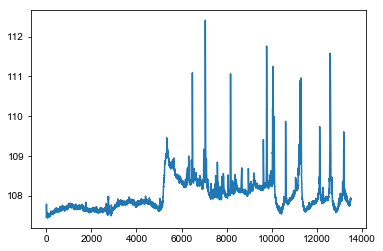

In [9]:
plt.plot(mn)

In [27]:
rois = ((slice(2000, 2420), slice(0,None), slice(None), slice(None)),
        (slice(9500, 9920), slice(0,None), slice(None), slice(None)))
results = []
cluster.start_workers(200)
for roi in rois:        
    data_tx = data[roi].map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
    data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))
    ds_xy = 2
    data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
    rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], data_ds.shape[1], 'auto','auto'))
    data_dff = rechunked.map_blocks(mydff, dtype='float32').max(1)
    results.append(data_dff.compute())

cluster.stop_workers(cluster.workers)

<Future finished result=None>

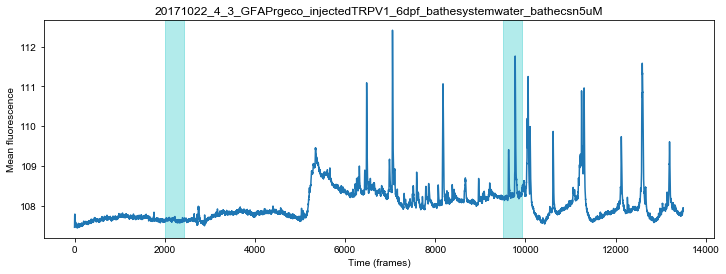

In [28]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(mn)
axs.set_xlabel('Time (frames)')
axs.set_ylabel('Mean fluorescence')
axs.set_title(dset.metadata['data_header'])
for r in rois:
    axs.axvspan(r[0].start, r[0].stop, color='c', alpha=.3)

In [12]:
#out_path = '/groups/ahrens/ahrenslab/projects/ngm/'
#out_fnames = exp_name + f'_t{start}_t{stop}.tif'

In [13]:
#print(out_path + out_fname)
#from skimage.io import imsave
#imsave(out_path + out_fname, result, imagej=True)

In [29]:
for ind, r in enumerate(results):
    fname = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{rois[ind][0].start}t{rois[ind][0].stop}.mp4'
    clim = (0,.6)
    cmap='inferno'
    nparray_to_video(fname, r, clim=clim, cmap=cmap)

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420.mp4


100%|██████████| 420/420 [00:03<00:00, 120.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420.mp4 

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t9500t9920.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t9500t9920.mp4


100%|██████████| 420/420 [00:02<00:00, 142.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t9500t9920.mp4 



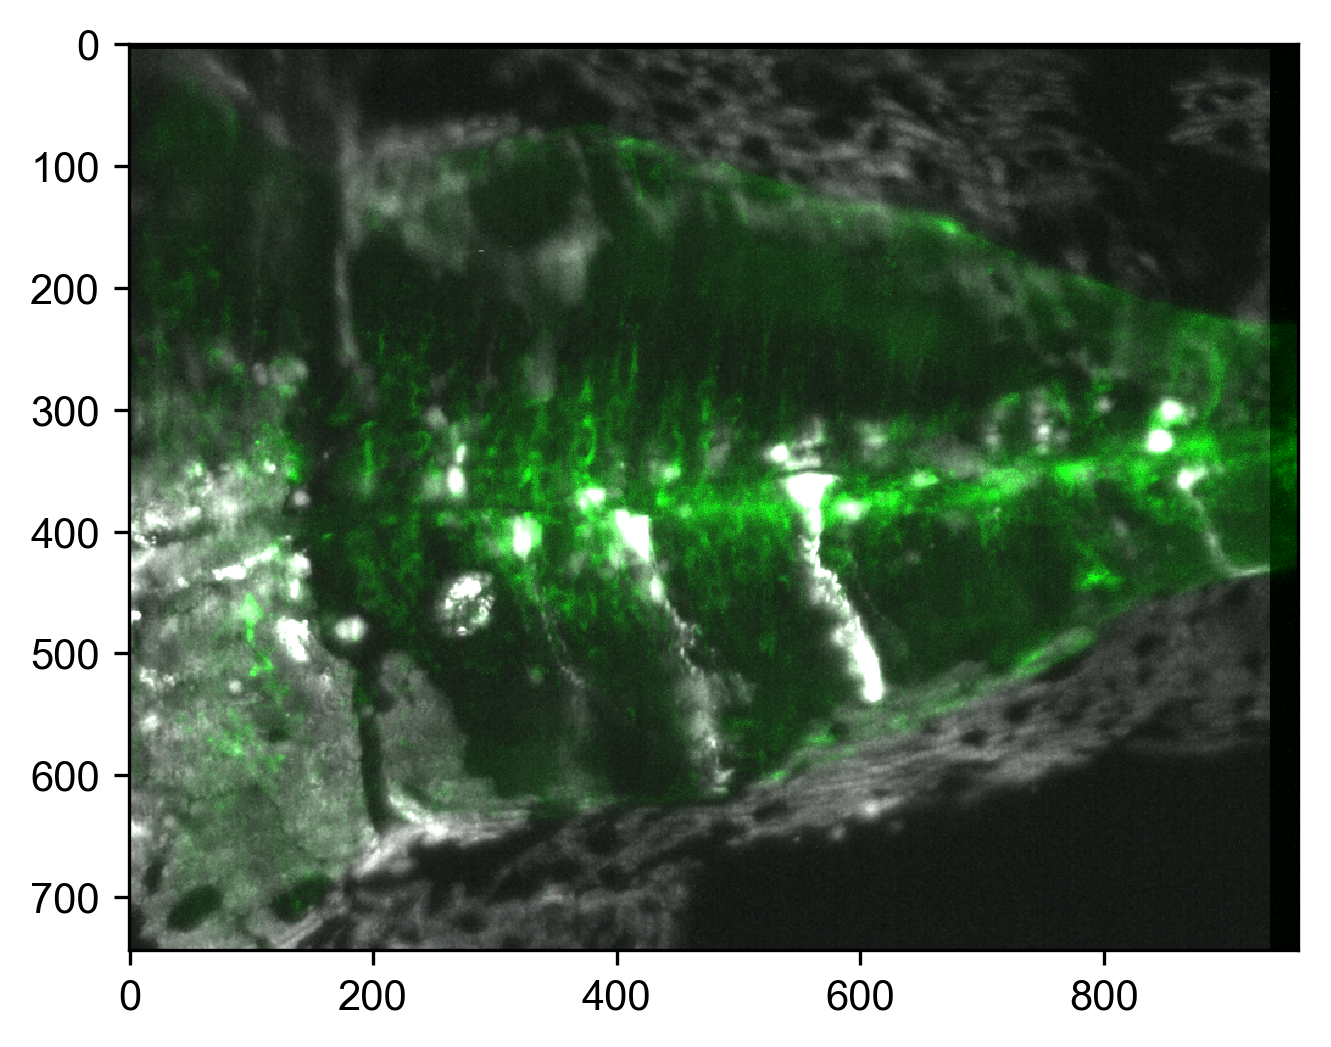

In [30]:
from skimage.io import imread
try:
    dset_g = ZDS(str(next(Path(base_dir).parent.glob('*GREEN*'))) + os.path.sep)
    dset_r = ZDS(str(next(Path(base_dir).parent.glob('*RED*'))) + os.path.sep)
    anat_g = dset_g.data.mean(0).compute(scheduler='threads')
    anat_r = dset_r.data.mean(0).compute(scheduler='threads')    
except StopIteration:
    dset_g = ZDS(str(next(Path(base_dir).parent.glob('*green*'))) + os.path.sep)
    dset_r = ZDS(str(next(Path(base_dir).parent.glob('*red*'))) + os.path.sep)
    anat_g = dset_g.data.mean(0).compute(scheduler='threads')
    anat_r = dset_r.data.mean(0).compute(scheduler='threads')
except StopIteration:
    anat_g = imread(str(next(Path(base_dir).parent.glob('*TRPV1*'))))
    anat_r = imread(str(next(Path(base_dir).parent.glob('*RGECO*'))))
    dset_r = []
    dset_g = []

    
expn = dset.metadata['data_header']
sample = dset.data[-1].compute(scheduler='threads')

fig, axs = plt.subplots(dpi=300)

tx = estimate_translation(sample.max(0), anat_r.max(0))
r_tx= gray(rescale(tx.transform(anat_r.max(0)),in_range=(100,200), out_range=(0,1))) * np.array([1,1,1,.5])
g_tx = gray(rescale(tx.transform(anat_g.max(0)), in_range=(100,200), out_range=(0,1))) * np.array([1,1,1,1])
tmp = gray(rescale(sample.max(0).astype('float32'),in_range=(100,450), out_range=(0,1))) * np.array([0,1,0,1])
axs.imshow((g_tx + tmp).clip(0,1))

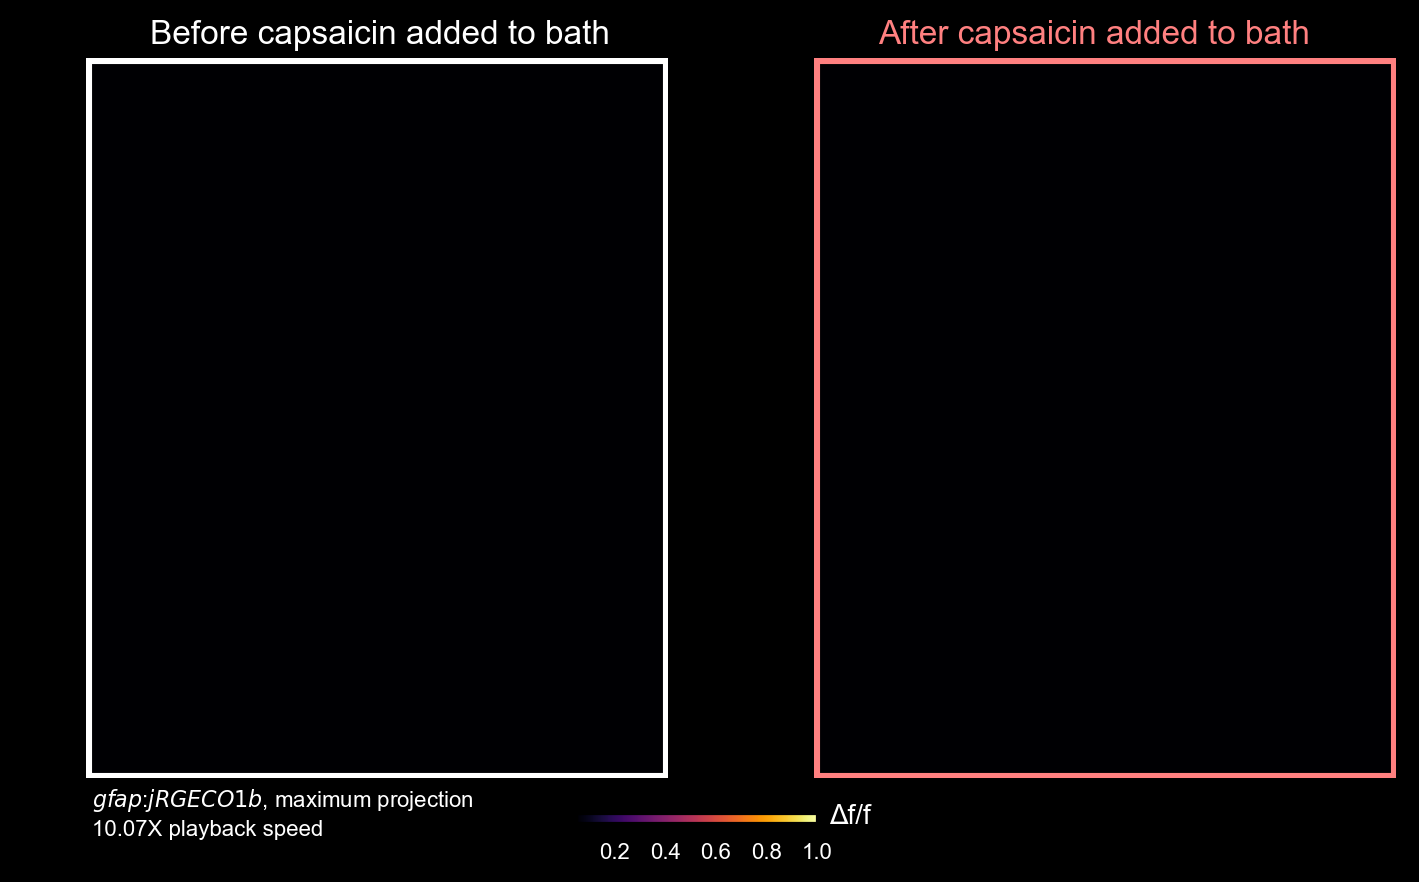

In [72]:
from matplotlib.patches import Rectangle
in_range_dff = (.05,1)
fps = 14
figsize = (8, 4.5)

crop = slice(None), slice(None), slice(10,-10)
dff_ = results[0][crop], results[1][crop]

anat_rgeco = downscale(anat_ref[crop[0]], (1,2,2))[:,crop[1], crop[2]].max(0)
anat_rgeco_rgb = gray(rescale(anat_rgeco, in_range=(100,300), out_range=(0,1))) * np.array([.25,.25,.25,1])

fig_dff, axs_dff = plt.subplots(dpi=200, figsize=figsize, ncols=2)

fig_dff.set_facecolor('k')
rect_colors = ['w', (1,.5,.5)]
for ind_ax, ax in enumerate(axs_dff):
    ax.set_facecolor('k')
    ax.axis('off')
    ax.imshow(np.zeros(dff_[0][0].shape[::-1]), clim=in_range_dff, cmap='inferno')
    ax.add_patch(Rectangle((0,0), 1,1, transform=ax.transAxes, fill=False, linewidth=4, color=rect_colors[ind_ax]))

axs_dff[0].set_position([.05,.1,.45,.8])
axs_dff[1].set_position([.505,.1,.45,.8])

axs_cbar = fig_dff.add_axes([.4, .05, .15, .01])
cbar = plt.colorbar(axs_dff[0].images[0], cax=axs_cbar, orientation='horizontal')
axs_cbar.text(1.05, 0, '\u0394f/f', transform=axs_cbar.transAxes, fontdict={'fontsize' : 10, 'color' : 'w'})
axs_cbar.tick_params(labelcolor='w', labelsize=8)
axs_cbar.set_xticks([0,1])
fd_small = {'fontsize' : 8, 'color' : 'w'}

#trp_label = dict(x = .01, y=-.1, s='$\it{gfap}$:TRPV1-T2A-GFP', transform=axs.transAxes, fontdict=dict(color='y', size=8))
condition_labels = (dict(x=.11, y = 1.02, s='Before capsaicin added to bath', transform=axs_dff[0].transAxes, fontdict={'fontsize' : 12, 'color' : rect_colors[0]}),
                    dict(x=.11, y = 1.02, s='After capsaicin added to bath', transform=axs_dff[1].transAxes, fontdict={'fontsize' : 12, 'color' : rect_colors[1]}))
rgeco_label = dict(x = .01, y=-.04, s='$\it{gfap}$:$\it{jRGECO1b}$, maximum projection', transform=axs_dff[0].transAxes, fontdict=dict(color='w', size=8))
timing_label = dict(x = .01, y =-.08, s=f'{fps/dset.metadata["volume_rate"]:.2f}X playback speed',transform=axs_dff[0].transAxes, fontdict=dict(color='w', size=8))

#axs.text(**trp_label)
axs_dff[0].text(**condition_labels[0])
axs_dff[1].text(**condition_labels[1])
axs_dff[0].text(**rgeco_label)
axs_dff[0].text(**timing_label)
ind = 0
def draw_frame(t_):
    global ind
    if ind == results[0].shape[0]:
        ind = 0
    for ind_im, d in enumerate(dff_):
        chunk_rgb = inferno(rescale(dff_[ind_im][ind],in_range=in_range_dff, out_range=(0,1)))    
        composite = (anat_rgeco_rgb + chunk_rgb).transpose(1,0,2)
        if len(axs_dff[ind_im].images) == 0:
            axs_dff[ind_im].imshow(composite)
        else:
            axs_dff[ind_im].images[0].set_data(composite)
    ind += 1
    return mplfig_to_npimage(fig_dff)

(-0.5, 1599.5, 899.5, -0.5)

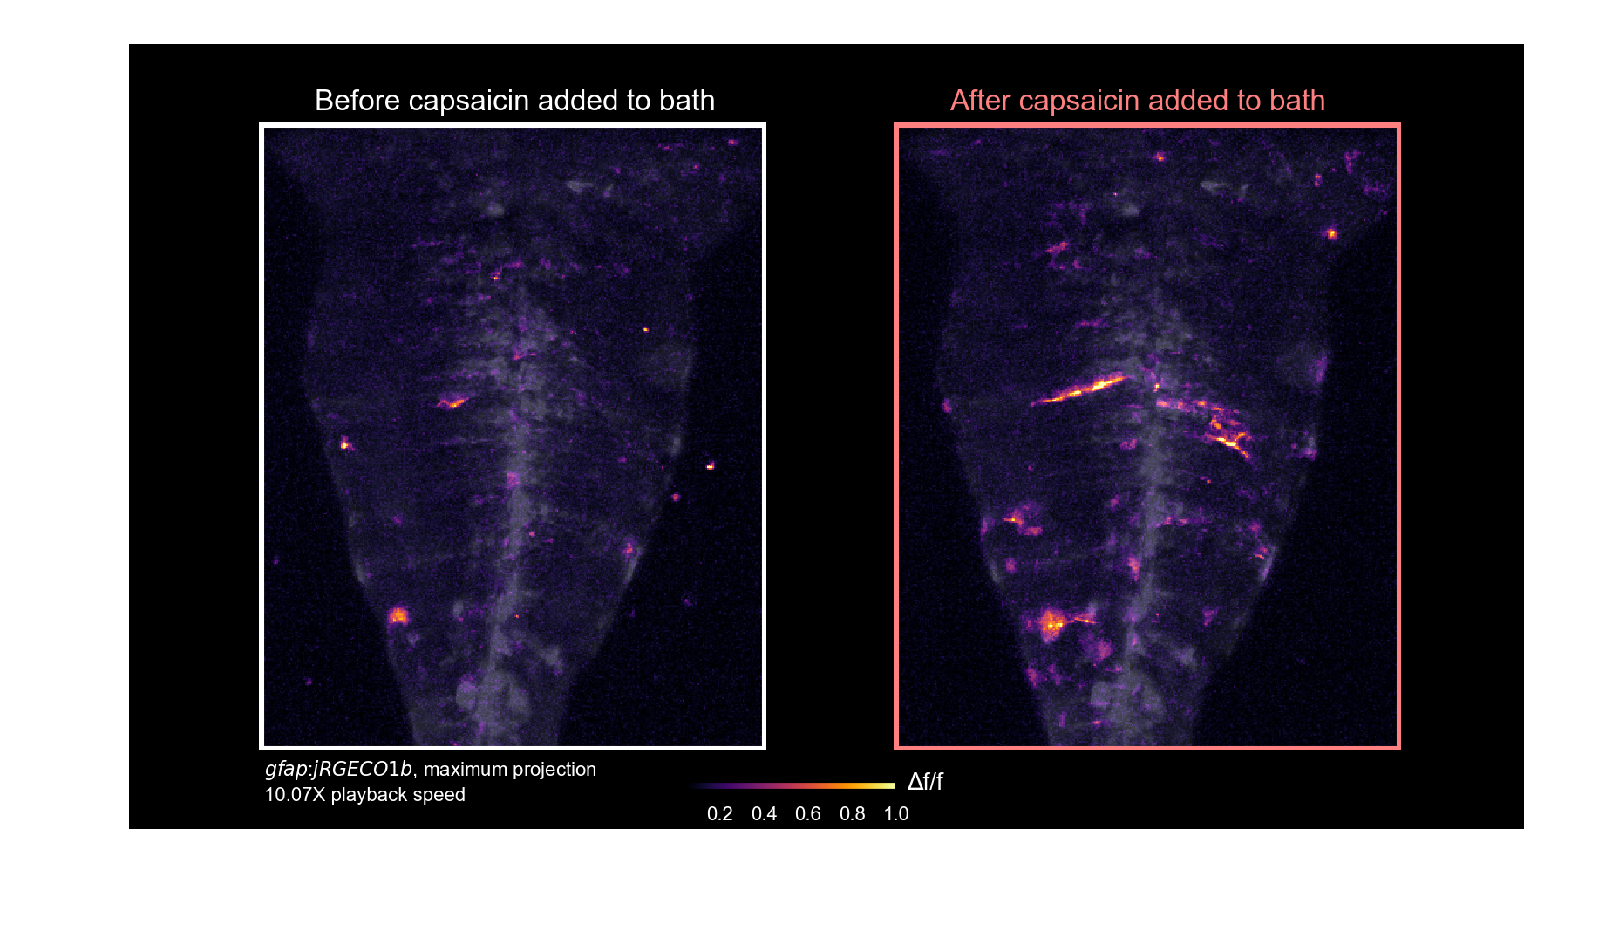

In [73]:
fig, axs_ = plt.subplots(dpi=300)
plt.imshow(draw_frame(0))
axs_.axis('off')

In a $\it{Tg(gfap}$:$\it{jRGECO1b)}$ fish transiently expressing TRPV1 
            in a sparse set of astroglia, adding capsaicin to the bath (right panel) 
            elevates astroglial calcium activity relative to baseline (left panel).


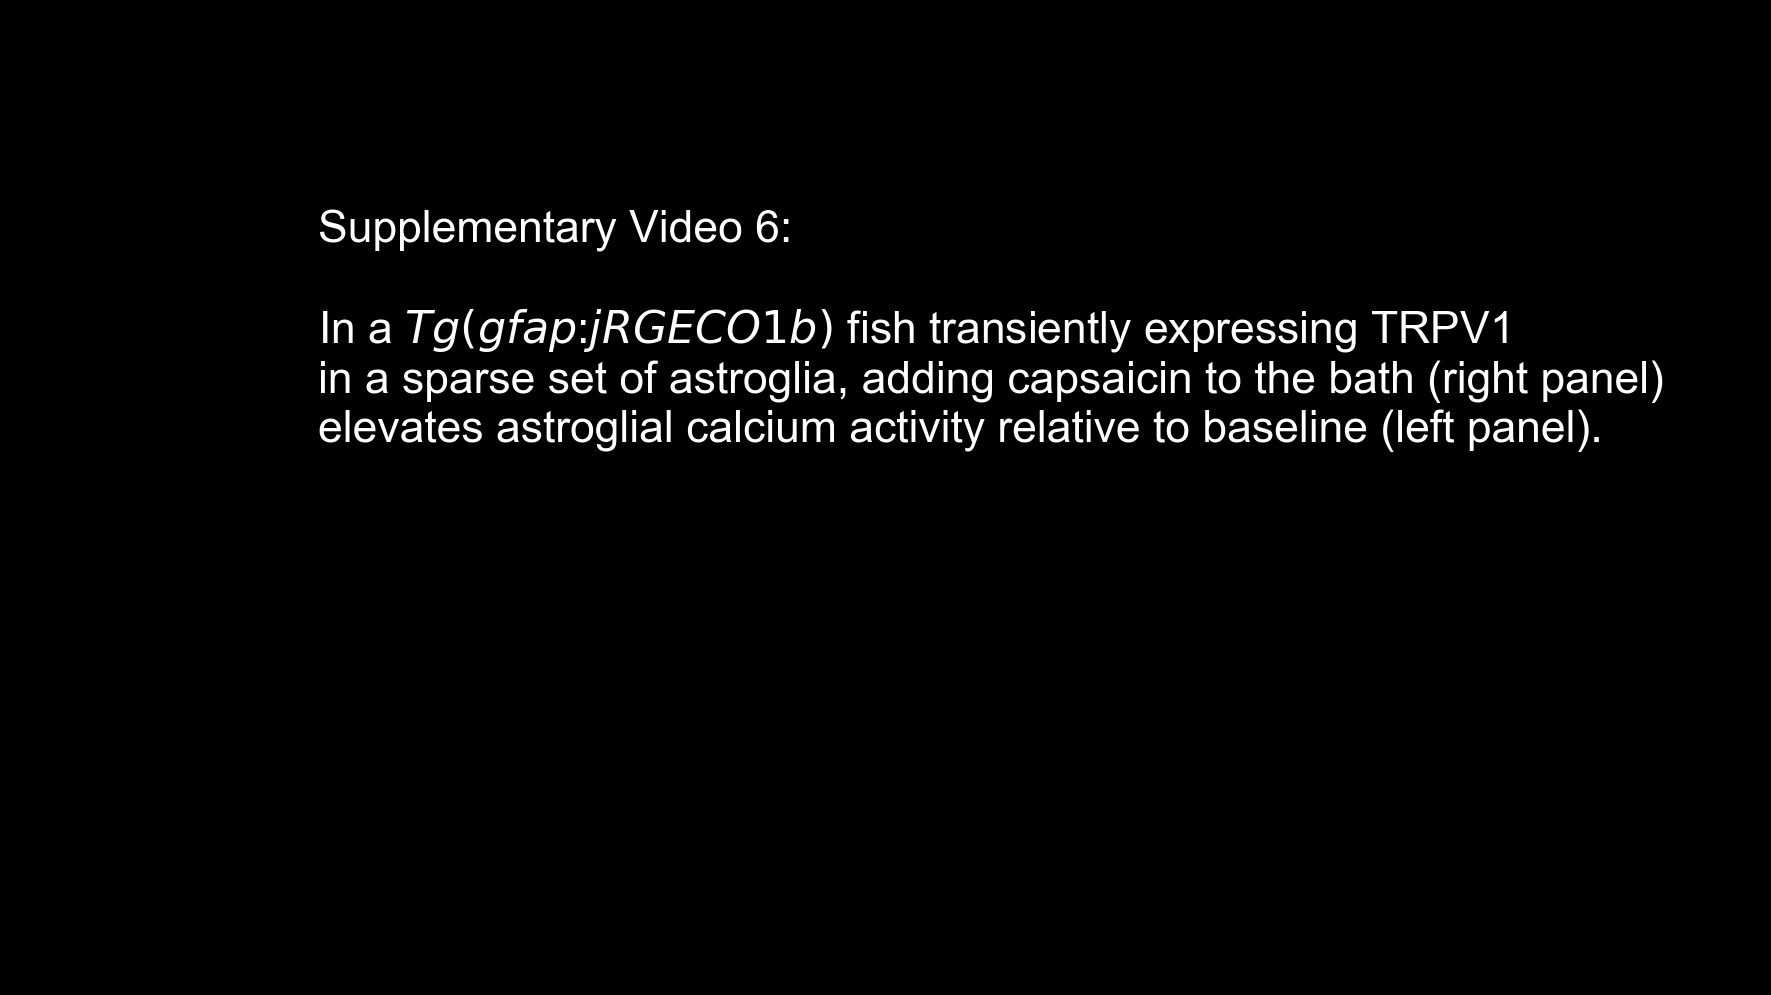

In [74]:
## make the title card 
title_dur = 4
fig_intro = plt.figure(dpi=200, figsize=figsize, facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')
intro_text ='''Supplementary Video 6:
                                
In a $\it{Tg(gfap}$:$\it{jRGECO1b)}$ fish transiently expressing TRPV1 
in a sparse set of astroglia, adding capsaicin to the bath (right panel) 
elevates astroglial calcium activity relative to baseline (left panel).            
'''
            
ax_intro.text(.15,
              .8,
              intro_text, 
              fontdict=dict(color='w', size=16), 
              transform=ax_intro.transAxes, 
              ha = 'left',
              va='top',
              multialignment='left')

def drawf_intro(t_):
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

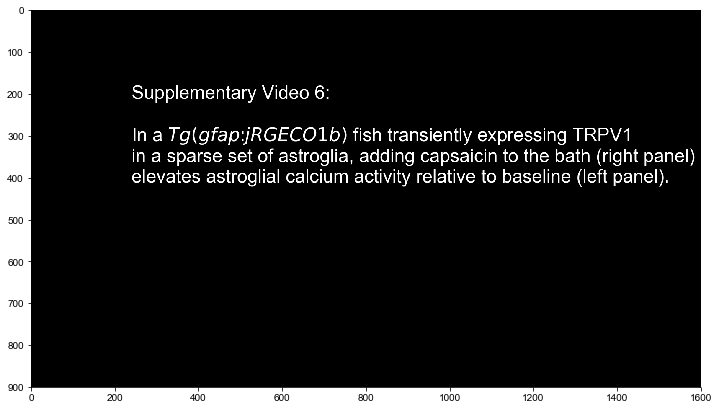

In [75]:
_,_  = plt.subplots(figsize=(12,12))
plt.imshow(drawf_intro(0))

In [76]:
import shutil
data_dur = results[0].shape[0] / fps
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{rois[0][0].start}t{rois[0][0].stop}_t{rois[1][0].start}t{rois[1][0].stop}.mp4'
ind = 0 

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])
shutil.copyfile(vid_fname, '/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_6.mp4')

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420_t9500t9920.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420_t9500t9920.mp4


100%|█████████▉| 476/477 [01:11<00:00,  6.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_t2000t2420_t9500t9920.mp4 



'/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_6.mp4'